# Thư viện

In [ ]:
%%capture
!pip install opencv-python numpy pillow
!pip install gdown

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

import gdown

import glob
import re
from typing import List, Optional

import PIL.Image
import torch
import torch.nn.functional as F


# Tạo vết xước cho ảnh

In [20]:
def add_scratches(image, num_scratches=5):
    height, width, _ = image.shape
    for _ in range(num_scratches):
        x1, y1 = random.randint(0, width-1), random.randint(0, height-1)
        x2, y2 = random.randint(0, width-1), random.randint(0, height-1)

        thickness = random.randint(5, 10)

        # Vẽ đường thẳng ngẫu nhiên trên ảnh
        color = (random.randint(230, 255),) * (3 if len(image.shape) == 3 else 1)  # Màu xước sáng
        image = cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

# def add_blemishes(image, num_blemishes=2):
#     height, width, _ = image.shape
#     for _ in range(num_blemishes):
#         x, y = random.randint(0, width), random.randint(0, height)

#         radius = random.randint(5, 10)  # Bán kính điểm ố từ 5 đến 10

#         color = (random.randint(200, 255), random.randint(200, 255), random.randint(200, 255))  # Màu tối cho vết ố
#         image = cv2.circle(image, (x, y), radius, color, -1)  # -1 để vẽ đầy hình tròn
#     return image

def process_image(image_path, resolution=512, isTest = False):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if image is None:
        print("Error: Unable to read the image.")
        return

    image_with_scratches = add_scratches(image, random.randint(1,5))
    # image_with_blemishes = add_blemishes(image_with_scratches, random.randint(1,5))

    image_resized = cv2.resize(image_with_scratches, (resolution, resolution))

    if(isTest):
        cv2.imwrite('../data/test_output.png', image_resized)

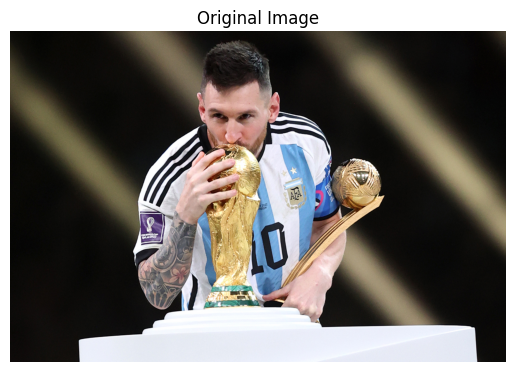

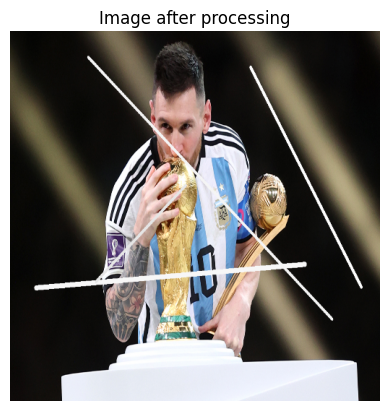

In [21]:
# %cd /content

# test with a image
process_image('../data/messi.jpg', isTest = True)

image = cv2.imread('../data/messi.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

test_output = cv2.imread('../data/test_output.png')
plt.imshow(test_output)
plt.title('Image after processing')
plt.axis('off')
plt.show()

# Tạo mask bọc vết xước

In [22]:
def ScratchMask(image_path, min_line_length=20, max_line_gap=5, mask_size=(256, 256), isTest=False):
    """
    Tạo một mask với các vết xước dựa trên ảnh đầu vào.

    Args:
        image (ndarray): Ảnh đầu vào (RGB).
        min_line_length (int): Chiều dài tối thiểu của các đường thẳng.
        max_line_gap (int): Khoảng cách tối đa giữa các đoạn để nối thành một đường.
        mask_size (tuple): Kích thước của mask (mặc định là 256x256).

    Returns:
        mask (ndarray): Mặt nạ với các vết xước (0: vết xước, 1: vùng không bị che).
    """

    gray_image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)

    if mask_size is None:
        mask_size = (gray_image.shape[1], gray_image.shape[0])  # (width, height)

    # Áp dụng Thresholding để phân biệt vùng sáng và tối
    _, thresh_image = cv2.threshold(gray_image, 230, 255, cv2.THRESH_BINARY)

    # Tìm cạnh sử dụng Canny Edge Detector
    edges = cv2.Canny(thresh_image, 50, 150)

    # Tìm các đường thẳng sử dụng phép biến đổi Hough Line
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    # Khởi tạo mask trắng với kích thước `mask_size` (giá trị mặc định là 1.0)
    mask = np.ones(mask_size, dtype=np.float32)

    # Vẽ các đường thẳng (vết xước) lên mask
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Tính toán tỉ lệ giữa kích thước gốc và mask
            scale_x = image.shape[1] / mask_size[1]
            scale_y = image.shape[0] / mask_size[0]
            # Điều chỉnh tọa độ để vẽ chính xác lên mask
            x1, y1, x2, y2 = int(x1 / scale_x), int(y1 / scale_y), int(x2 / scale_x), int(y2 / scale_y)
            cv2.line(mask, (x1, y1), (x2, y2), color=0.0, thickness=10)  # Vẽ đường thẳng với giá trị 0.0 (vết xước)

    if(isTest):
        cv2.imwrite('../data/test_mask.png', (mask * 512).astype(np.float32))
        # Hiển thị mask
        plt.imshow(mask, cmap='gray')
        plt.title("Scratch Mask")
        plt.axis("off")
        plt.show()

    return mask

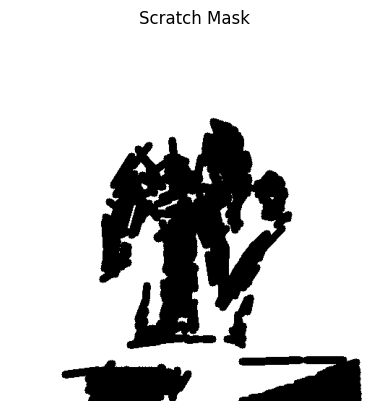

In [23]:
# %cd /content
# Tạo mask với các vết xước
mask = ScratchMask('../data/messi.jpg', min_line_length=30, max_line_gap=10, mask_size=(512, 512), isTest=True)

# Chạy thử code

In [ ]:
# %%capture
# #download code
# !git clone https://github.com/fenglinglwb/MAT.git
# %cd MAT
# !pip install -r requirements.txt

In [ ]:
#download mô hình
# file_id = '12YcowyEVMyRUJ8MsfZDvD5i_AihR_CYz'

# if not os.path.exists('../model/MAT'):
#     os.makedirs('../model/MAT')
# output_path = '../model/MAT/Places_512_FullData.pkl'

# gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)
# print(f"Model downloaded to {output_path}")

Downloading...
From (original): https://drive.google.com/uc?id=12YcowyEVMyRUJ8MsfZDvD5i_AihR_CYz
From (redirected): https://drive.google.com/uc?id=12YcowyEVMyRUJ8MsfZDvD5i_AihR_CYz&confirm=t&uuid=49f95aa5-17b7-41b5-9479-80c8f0e9a00d
To: d:\GENERATIVE_AI\GenerativeCV\image-inpainting-app\model\MAT\Places_512_FullData.pkl
100%|██████████| 661M/661M [06:59<00:00, 1.58MB/s] 

Model downloaded to ../model/MAT/Places_512_FullData.pkl


In [2]:
import os
if os.path.basename(os.getcwd()) != 'image-inpainting-app':
    os.chdir('..')

In [3]:
import pyspng
import legacy

from libs.MAT import dnnlib, generate_image
from libs.MAT.datasets.mask_generator_256 import RandomMask
from libs.MAT.networks.mat import Generator


import dnnlib

import generate_image

ModuleNotFoundError: No module named 'libs.MAT'

In [ ]:

def read_and_convert_to_ones(imask, resolution):
    """
    Đọc mask từ file và chuyển đổi thành ma trận với giá trị 1.0.

    Args:
        imask (str): Đường dẫn đến file mask.
        resolution (tuple): Độ phân giải mong muốn (width, height).

    Returns:
        mask (ndarray): Ma trận với toàn giá trị 1.0 có kích thước `resolution`.
    """
    # Đọc mask từ file ở dạng grayscale
    mask = cv2.imread(imask, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        raise FileNotFoundError(f"Không tìm thấy file mask: {imask}")

    # Resize mask về độ phân giải mong muốn
    mask_resized = cv2.resize(mask, (resolution, resolution), interpolation=cv2.INTER_AREA)

    mask_binary = (mask_resized > 127).astype(np.float32)  # Các giá trị khác 0 sẽ trở thành 1

    return mask_binary[np.newaxis, ...]  # Thêm chiều nếu cần thiết

def generate_images(
    network_pkl: str, # đường dẫn tới mô hình
    ipath: str,  # đường dẫn tới hình ảnh cần khôi phục
    imask: str = None,
    resolution = 512, # độ phân giải hình ảnh
    truncation_psi = 1,
    noise_mode = "const",
    outputpath = 'output.png',
):
    """
    Generate images using pretrained network pickle.
    """
    seed = 240  # pick up a random number
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


    print(f'Loading networks from: {network_pkl}')
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as f:
        G_saved = legacy.load_network_pkl(f)['G_ema'].to(device).eval().requires_grad_(False) # type: ignore
    net_res = 512 if resolution > 512 else resolution

    G = Generator(z_dim=512, c_dim=0, w_dim=512, img_resolution=net_res, img_channels=3).to(device).eval().requires_grad_(False)
    generate_image.copy_params_and_buffers(G_saved, G, require_all=True)

    # os.makedirs(outdir, exist_ok=True)

    # no Labels.
    label = torch.zeros([1, G.c_dim], device=device)

    def read_image(image_path):
        with open(image_path, 'rb') as f:
            if pyspng is not None and image_path.endswith('.png'):
                image = pyspng.load(f.read())
            else:
                image = np.array(PIL.Image.open(f))
        if image.ndim == 2:
            image = image[:, :, np.newaxis] # HW => HWC
            image = np.repeat(image, 3, axis=2)
        image = image.transpose(2, 0, 1) # HWC => CHW
        image = image[:3]
        return image

    def to_image(image, lo, hi):
        image = np.asarray(image, dtype=np.float32)
        image = (image - lo) * (255 / (hi - lo))
        image = np.rint(image).clip(0, 255).astype(np.uint8)
        image = np.transpose(image, (1, 2, 0))
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)
        return image
    def resize_tensor(tensor, target_size):
        """
        Resize tensor đến kích thước target_size (H, W) bằng bilinear interpolation.
        """
        return F.interpolate(tensor, size=target_size, mode='bilinear', align_corners=False)

    if resolution != 512:
        noise_mode = 'random'
    with torch.no_grad():
        image = read_image(ipath)
        image = (torch.from_numpy(image).float().to(device) / 127.5 - 1).unsqueeze(0)

        mask = None
        if imask:
            mask = read_and_convert_to_ones(imask, 512)
            mask = torch.from_numpy(mask).float().to(device).unsqueeze(0)
        else:
            mask = RandomMask(resolution)
            mask = torch.from_numpy(mask).float().to(device).unsqueeze(0)


        z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)
        output = G(image, mask, z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        output = (output.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
        output = output[0].cpu().numpy()
        PIL.Image.fromarray(output, 'RGB').save(outputpath)


ModuleNotFoundError: No module named 'libs.MAT'

In [25]:
# %cd /content/MAT
generate_images(
    network_pkl = "../model/MAT/Places_512_FullData.pkl",
    ipath = "../data/messi.jpg",
    imask = "../data/test_mask.png",
    outputpath="../data/output_1.png"
)
output = cv2.imread("../data/output_1.png")
plt.imshow(output)
plt.axis("off")
plt.show()

Loading networks from: ../model/MAT/Places_512_FullData.pkl


NameError: name 'dnnlib' is not defined